## модель ARIMA 1

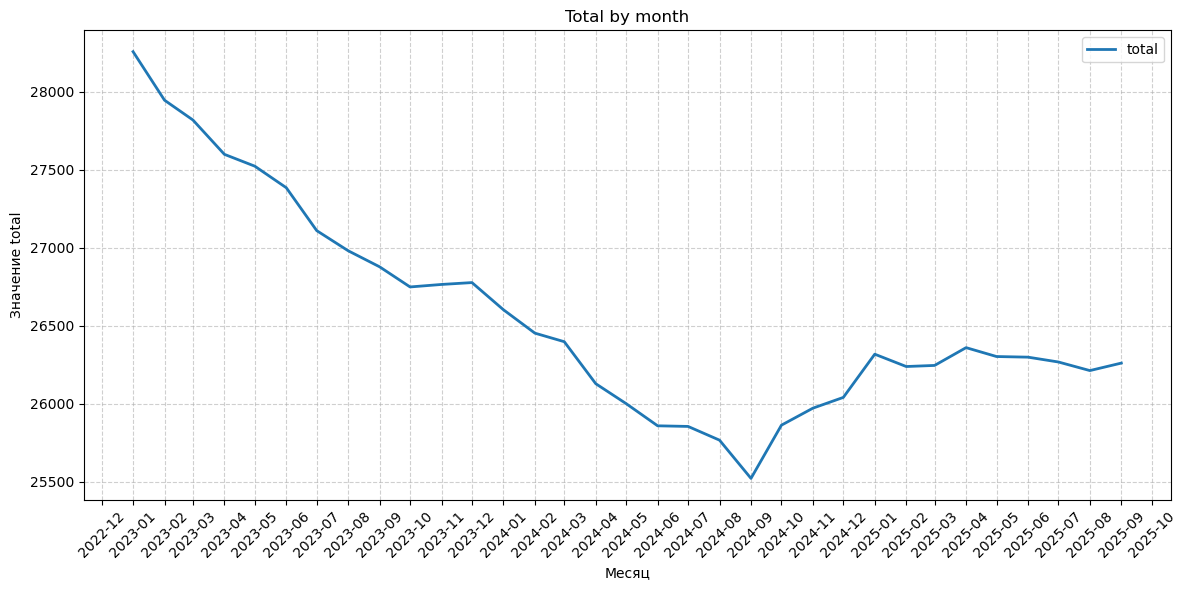

In [246]:

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# если работаешь в Jupyter, добавь в самой первой ячейке:
# %matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) читаем и ЖЕСТКО парсим дату + приводим числовой столбец
df = pd.read_excel('forecast.xlsx')
df['date']  = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')
df['total'] = pd.to_numeric(df['total'], errors='coerce')

# 2) убираем битые строки и ставим равномерный месячный индекс
df = df.dropna(subset=['date', 'total']).set_index('date').asfreq('MS')

# 3) рисуем
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['total'], label='total', linewidth=2)

# ось X — каждый месяц
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.set_title('Total by month')
ax.set_xlabel('Месяц'); ax.set_ylabel('Значение total')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()


## проверка на стационарность Дики-Фуллер

In [248]:
def test_stationarity(series, title=''):
    print(f"Results of ADF Test on {title}:")
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Non-stationary")
    else:
        print("stationary")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    print("\n")

test_stationarity(df['total'], 'Counts')

Results of ADF Test on Counts:
ADF Statistic: -1.827473740773018
p-value: 0.3669095516535523
Non-stationary
Critical Value (1%): -3.6790595944893187
Critical Value (5%): -2.9678817237279103
Critical Value (10%): -2.6231583472057074




## Разделение данных на трейн и тест

In [250]:
# ==== Разделение 80/20 ====
train_size = int(len(df) * 0.7)

train = df.iloc[:train_size]   # первые 80% строк
test  = df.iloc[train_size:]   # последние 20% строк

print("Размер train:", train.shape)
print("Размер test :", test.shape)


Размер train: (23, 3)
Размер test : (10, 3)


## Первое дифференциирование

In [252]:
# первое дифференцирование
train_diff1 = train["total"].diff().dropna()

# проверка снова
print("ADF p-value после 1 diff:", adfuller(train_diff1)[1])
test_stationarity(train_diff1, "Train after 1st diff")

ADF p-value после 1 diff: 0.5354889049847875
Results of ADF Test on Train after 1st diff:
ADF Statistic: -1.4960004866966647
p-value: 0.5354889049847875
Non-stationary
Critical Value (1%): -4.137829282407408
Critical Value (5%): -3.1549724074074077
Critical Value (10%): -2.7144769444444443




## модель ARIMA

                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:                   23
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -142.366
Date:                Tue, 16 Sep 2025   AIC                            294.731
Time:                        22:27:35   BIC                            300.186
Sample:                    01-01-2023   HQIC                           296.016
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1001      0.295      3.726      0.000       0.521       1.679
ar.L2         -0.5027      0.316     -1.590      0.112      -1.122       0.117
ma.L1         -1.3393      2.974     -0.450      0.6

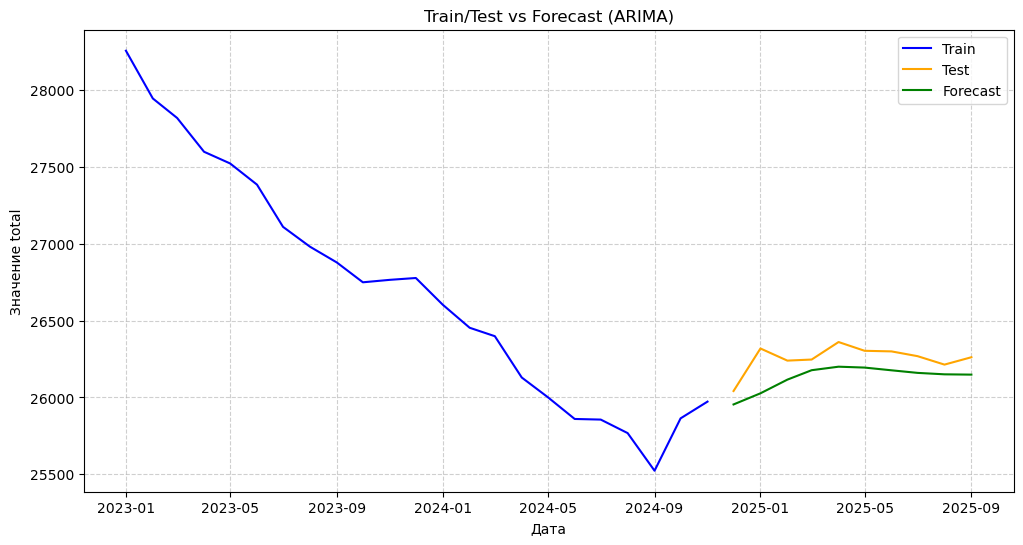

In [254]:
model = ARIMA(train["total"], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test))
mape = np.mean(np.abs((test["total"] - forecast) / test["total"])) * 100
print("MAPE:", mape)

plt.figure(figsize=(12,6))
plt.plot(train.index, train["total"], label="Train", color="blue")
plt.plot(test.index, test["total"], label="Test", color="orange")
plt.plot(test.index, forecast, label="Forecast", color="green")

plt.title("Train/Test vs Forecast (ARIMA)")
plt.xlabel("Дата")
plt.ylabel("Значение total")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### выгрузка

In [259]:
forecast = pd.Series(forecast.values, index=test.index, name="forecast")
print (forecast)

date
2024-12-01    25954.609877
2025-01-01    26027.113632
2025-02-01    26116.117286
2025-03-01    26177.574989
2025-04-01    26200.435361
2025-05-01    26194.685258
2025-06-01    26176.866823
2025-07-01    26160.156434
2025-08-01    26150.732288
2025-09-01    26148.766336
Freq: MS, Name: forecast, dtype: float64


### новый прогноз

In [266]:
# обучаем модель на train (как раньше)
model = ARIMA(train["total"], order=(p, d, q))
model_fit = model.fit()

# прогноз на 12 месяцев вперёд от конца train
future_forecast = model_fit.forecast(steps=12)

# создаём даты для прогноза
future_dates = pd.date_range(start=train.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq="MS")

# объединяем в Series
future_forecast = pd.Series(future_forecast.values, index=future_dates, name="forecast")

print(future_forecast)


2024-12-01    25954.609877
2025-01-01    26027.113632
2025-02-01    26116.117286
2025-03-01    26177.574989
2025-04-01    26200.435361
2025-05-01    26194.685258
2025-06-01    26176.866823
2025-07-01    26160.156434
2025-08-01    26150.732288
2025-09-01    26148.766336
2025-10-01    26151.341654
2025-11-01    26155.163023
Freq: MS, Name: forecast, dtype: float64
